In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import time
ipl_matches = pd.read_csv('all_matches.csv')
ipl_matches.head(5)
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def colors_from_values(values: pd.Series, palette_name:str, ascending):
    '''Returns a seaborn palette reordered by value
    Parameters:
    values: pd.Series
    palette_name:str, Seaborn valid palette name
    ascending: bool, optional color sort order
    '''
    # convert to indices
    values = values.sort_values(ascending=ascending).reset_index()
    indices = values.sort_values(by=values.columns[1]).index
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

In [3]:
def match_conv(sample_match):
    sample_match['Bat Balls'] = np.where(sample_match['extras'] == 0,'Legal','No')
    sample_match['player_dismissed'].replace(np.nan,'miss',inplace = True)
    sample_match['wicket_type'].replace(np.nan,'miss',inplace = True)
    sample_match.replace(np.nan,0,inplace= True)
    sample_match['bowler_extras'] = sample_match['wides'] + sample_match['noballs']
    sample_match['Total Runs'] = sample_match['runs_off_bat'] + sample_match['bowler_extras']
    sample_match['is_dot'] = np.where(sample_match['Total Runs'] == 0,1,0)     
    sample_match['Bowl Balls'] = np.where(sample_match['bowler_extras'] == 0,'Legal','No')
    return sample_match
def getting_batting_stats(teams):

    teams['Strike Rate'] = (teams['Total Runs']/teams['Balls'])*100
    teams['Dot Percent'] = (teams['Dot Count']/teams['Balls'])*100
    teams['Boundary Percent'] = ((teams['Four Count']*4 + teams['Six Count']*6)/teams['Total Runs'])*100
    teams['Balls Per Boundary'] = teams['Balls']/(teams['Four Count']+ teams['Six Count'])
    teams['Strike Rotation'] = (teams['Total Runs'] - (teams['Four Count']*4 + teams['Six Count']*6)) / (teams['Balls'] - (teams['Four Count']+ teams['Six Count']))
    #teams['Average'] = np.where(teams['Got Out'] == 0,teams['Total Runs'],teams['Total Runs']/teams['Got Out'])
    return teams
ipl_matches['seasons'] = ipl_matches['season'].astype(str)
ipl_matches['seasons'].replace('2020/21','2020',inplace = True)
ipl_matches['seasons'].replace('2009/10','2010',inplace = True)
ipl_matches['seasons'].replace('2007/08','2008',inplace = True)
ipl_matches['seasons'].replace('2020/21','2021',inplace = True)
ipl_matches = match_conv(ipl_matches)
ipl_matches.shape

(200664, 28)

In [4]:
ipl_from_2018 = ipl_matches[ipl_matches['seasons'].isin(['2018','2019','2020','2021'])].reset_index(drop = True)
ipl_from_2018['over'] = (ipl_from_2018['ball'].map(str).str.split('.').str[0]).map(int) + 1
def adding_over(data):
    overs = []
    for i in range(len(data)):
        
        if 1 <= data['over'][i] <= 6 :
            overs.append('Powerplay')
        elif 7<= data['over'][i] <= 15 :
            overs.append('Middle Overs')
        else :
            overs.append('Death')
    data['Over Type'] = overs
adding_over(ipl_from_2018)
ipl_from_2018.tail(5)

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,...,other_wicket_type,other_player_dismissed,seasons,Bat Balls,bowler_extras,Total Runs,is_dot,Bowl Balls,over,Over Type
50199,1254086,2021,2021-05-02,"Narendra Modi Stadium, Ahmedabad",2,17.2,Delhi Capitals,Punjab Kings,SO Hetmyer,S Dhawan,...,0.0,0.0,2021,Legal,0.0,6.0,0,Legal,18,Death
50200,1254086,2021,2021-05-02,"Narendra Modi Stadium, Ahmedabad",2,17.3,Delhi Capitals,Punjab Kings,SO Hetmyer,S Dhawan,...,0.0,0.0,2021,Legal,0.0,6.0,0,Legal,18,Death
50201,1254086,2021,2021-05-02,"Narendra Modi Stadium, Ahmedabad",2,17.4,Delhi Capitals,Punjab Kings,SO Hetmyer,S Dhawan,...,0.0,0.0,2021,Legal,0.0,4.0,0,Legal,18,Death
50202,1254086,2021,2021-05-02,"Narendra Modi Stadium, Ahmedabad",2,17.5,Delhi Capitals,Punjab Kings,SO Hetmyer,S Dhawan,...,0.0,0.0,2021,No,1.0,1.0,0,No,18,Death
50203,1254086,2021,2021-05-02,"Narendra Modi Stadium, Ahmedabad",2,17.6,Delhi Capitals,Punjab Kings,SO Hetmyer,S Dhawan,...,0.0,0.0,2021,No,1.0,1.0,0,No,18,Death


In [5]:
# Striker Non Striker Pairs
Batsman = ipl_from_2018.groupby(['striker','non_striker'],as_index=False).agg({'Bat Balls': lambda val :(val == 'Legal').sum(),'runs_off_bat':['sum',lambda val : (val == 4).sum(),lambda val : (val == 6).sum()],'is_dot': lambda val : (val == 1).sum()})
Batsman.columns = ['Striker','Non-Striker','Balls','Total Runs','Four Count','Six Count','Dot Count']
partnership = getting_batting_stats(Batsman)
partnership.head(5)

,Striker,Non-Striker,Balls,Total Runs,Four Count,Six Count,Dot Count,Strike Rate,Dot Percent,Boundary Percent,Balls Per Boundary,Strike Rotation
0,A Dananjaya,HH Pandya,3,2,0,0,2,66.666667,66.666667,0.0,inf,0.666667
1,A Dananjaya,M Markande,2,2,0,0,0,100.000000,0.000000,0.0,inf,1.000000
2,A Mishra,I Sharma,2,3,0,0,0,150.000000,0.000000,0.0,inf,1.500000
3,A Mishra,J Suchith,6,2,0,0,4,33.333333,66.666667,0.0,inf,0.333333
4,A Mishra,K Rabada,5,3,0,0,3,60.000000,60.000000,0.0,inf,0.600000


In [8]:
strike = partnership.groupby(['Striker'],as_index = False).agg({'Balls':'sum','Total Runs':'sum','Four Count':'sum','Six Count':'sum','Dot Count':'sum'})
strike = getting_batting_stats(strike)
strike

,Striker,Balls,Total Runs,Four Count,Six Count,Dot Count,Strike Rate,Dot Percent,Boundary Percent,Balls Per Boundary,Strike Rotation
0,A Dananjaya,5,4,0,0,2,80.000000,40.000000,0.000000,inf,0.800000
1,A Mishra,25,22,2,0,12,88.000000,48.000000,36.363636,12.500000,0.608696
2,A Nortje,6,7,0,0,3,116.666667,50.000000,0.000000,inf,1.166667
3,AB de Villiers,965,1589,120,89,280,164.663212,29.015544,63.813719,4.617225,0.760582
4,AD Hales,116,148,13,6,47,127.586207,40.517241,59.459459,6.105263,0.618557
...,...,...,...,...,...,...,...,...,...,...,...
216,Y Prithvi Raj,1,0,0,0,1,0.000000,100.000000,NaN,inf,0.000000
217,YBK Jaiswal,93,106,11,4,43,113.978495,46.236559,64.150943,6.200000,0.487179
218,YK Pathan,242,300,23,12,94,123.966942,38.842975,54.666667,6.914286,0.657005
219,YS Chahal,43,15,0,0,32,34.883721,74.418605,0.000000,inf,0.348837


In [6]:
non_strike = partnership.groupby(['Non-Striker'],as_index = False).agg({'Balls':'sum','Total Runs':'sum','Four Count':'sum','Six Count':'sum','Dot Count':'sum'})
non_strike = getting_batting_stats(non_strike)
non_strike

,Non-Striker,Balls,Total Runs,Four Count,Six Count,Dot Count,Strike Rate,Dot Percent,Boundary Percent,Balls Per Boundary,Strike Rotation
0,A Dananjaya,3,4,0,0,2,133.333333,66.666667,0.000000,inf,1.333333
1,A Mishra,43,52,2,4,22,120.930233,51.162791,61.538462,7.166667,0.540541
2,A Nortje,6,11,1,1,3,183.333333,50.000000,90.909091,3.000000,0.250000
3,AB de Villiers,879,1219,82,54,267,138.680319,30.375427,53.486464,6.463235,0.763122
4,AD Hales,113,144,15,5,40,127.433628,35.398230,62.500000,5.650000,0.580645
...,...,...,...,...,...,...,...,...,...,...,...
215,Y Prithvi Raj,6,13,1,1,2,216.666667,33.333333,76.923077,3.000000,0.750000
216,YBK Jaiswal,97,121,13,4,45,124.742268,46.391753,62.809917,5.705882,0.562500
217,YK Pathan,224,294,15,16,75,131.250000,33.482143,53.061224,7.225806,0.715026
218,YS Chahal,44,45,2,2,19,102.272727,43.181818,44.444444,11.000000,0.625000


In [9]:
partner = strike.merge(non_strike, left_on = 'Striker',right_on = 'Non-Striker')
partner['Balls Faced Total'] = partner['Balls_x'] + partner['Balls_y']
partner['Ball Percent'] = (partner['Balls_x'] / partner['Balls Faced Total']) *100
partner['Total Runs Scored'] = partner['Total Runs_x'] + partner['Total Runs_y']
partner['Run Percent'] = (partner['Total Runs_x']/partner['Total Runs Scored']) *100
partner['Total Dot Count'] = (partner['Dot Count_x'] + partner['Dot Count_y'])
partner['Average Boundary Percent'] = (partner['Boundary Percent_x'] + partner['Boundary Percent_y'])/2
partner['Total Boundaries'] = partner['Four Count_x'] + partner['Six Count_x'] + partner['Four Count_y'] + partner['Six Count_y']

In [157]:
sort_value = Widgets.Combobox(options = ['Ascending','Descending'],description = 'Sort Order',disabled  = False)
metric_d = Widgets.Combobox(options = list(partner.columns),description = 'Metric',disabled = False)
text = Widgets.Text(description = 'Type Something',disabled = False)
balls = 200
from ipywidgets import Box
items = [sort_value,metric_d,text]
box = Box(children = items)
box

Box(children=(Combobox(value='', description='Sort Order', options=('Ascending', 'Descending')), Combobox(valu…

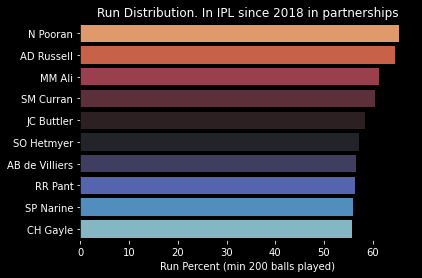

In [158]:
x = partner[partner['Balls_x'] >= 200]
new = x[['Striker',metric_d.value]]
if sort_value.value == 'Descending' :
    new_sort = new.sort_values(metric_d.value,ascending = False).head(10)
else :
    new_sort = new.sort_values(metric_d.value).head(10)
sns.barplot(x = metric_d.value,y= 'Striker',data = new_sort,palette= colors_from_values(new_sort[metric_d.value],"icefire",False))
plt.ylabel('')
plt.xlabel("Run Percent (min 200 balls played)")
plt.title(text.value + '. In IPL since 2018 in partnerships')
plt.show()

In [145]:
import ipywidgets as Widgets
player = Widgets.Combobox(options = list(set(partnership['Striker'].to_list())), description = 'Player',disabled = False)
player



Combobox(value='', description='Player', options=('LE Plunkett', 'CJ Jordan', 'AJ Tye', 'MK Lomror', 'N Pooran…

In [146]:
s = partnership[partnership['Striker'] == player.value]
ns = partnership[partnership['Non-Striker'] == player.value]
merger = s.merge(ns,left_on = 'Non-Striker',right_on = 'Striker').rename(columns = {'Striker_x':player.value,'Non-Striker_x':'Other Players'})
merger['Partnership'] = merger[player.value] + '-' + merger['Other Players']
merger['Ball Percent '+player.value] = (merger['Balls_x']/(merger['Balls_x'] + merger['Balls_y'])) * 100
merger['Ball Percent Others'] = 100 - merger['Ball Percent '+player.value]
merger['Run Percent '+player.value] = (merger['Total Runs_x']/(merger['Total Runs_x'] + merger['Total Runs_y'])) * 100
merger['Run Percent Others'] = 100 - merger['Run Percent '+player.value]
metrics = list(partnership.columns)
metrics.extend(['Ball Percent','Run Percent'])
metrics = [x for x in metrics if x not in ['Striker','Non-Striker']]
define = Widgets.Combobox(options = metrics,description = 'Choose a Metric')
define

Combobox(value='', description='Choose a Metric', options=('Balls', 'Total Runs', 'Four Count', 'Six Count', '…

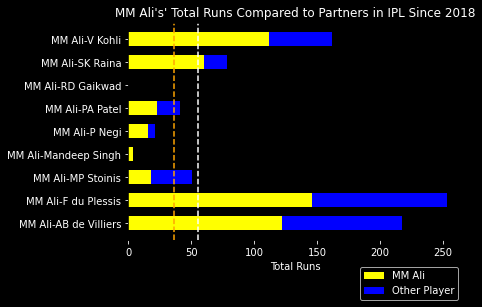

In [148]:
params = {'text.color':'white','xtick.color':'white','ytick.color':'white','axes.labelcolor' : 'white','figure.facecolor' : 'black','axes.facecolor':'black'}
plt.rcParams.update(params)
new_cols = [x for x in list(merger.columns) if define.value in x]
new_cols.append('Partnership')
new_df = merger[new_cols]
if not define.value in ['Run Percent','Ball Percent'] :
    new_df.columns.values[0] = new_df.columns.values[0].replace('_x',' '+player.value)
    new_df.columns.values[1] = new_df.columns.values[1].replace('_y',' Other Player')
import numpy as np
new_df.replace(np.nan,0,inplace = True)
br1 = np.arange(len(new_df))
br2 = [x + 0 for x in br1]
width = 0.6
plt.barh(br1,new_df.iloc[:,0],width,color = 'yellow',label = player.value)
plt.barh(br2,new_df.iloc[:,1],width,color = 'blue',label = 'Other Player',left = list(new_df.iloc[:,0]))
plt.axvline(new_df.iloc[:,0].mean(),linestyle = '--',color = 'white')
plt.axvline(new_df.iloc[:,1].mean(),linestyle = '--',color = 'orange')
plt.yticks([r + 0 for r in range(len(new_df))],new_df['Partnership'].to_list())
plt.gca().legend((player.value,'Other Players'))
plt.legend(bbox_to_anchor = (1,-0.1))
plt.xlabel(define.value)
plt.title(player.value +"'s' " + define.value + ' Compared to Partners in IPL Since 2018' )
plt.show()

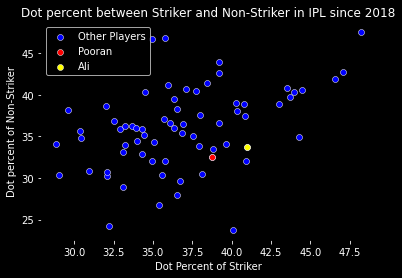

In [153]:
balls = 200
new_balls = partner[partner['Balls_x']>=150]
pooran = new_balls[new_balls['Striker'] == 'N Pooran']
ali = new_balls[new_balls['Striker'] == 'MM Ali']
kishan = new_balls[new_balls['Striker'] == 'Ishan Kishan']
sns.scatterplot('Dot Percent_x','Dot Percent_y',data = new_balls,color = 'blue')
sns.scatterplot('Dot Percent_x','Dot Percent_y',data = pooran,color = 'red')
sns.scatterplot('Dot Percent_x','Dot Percent_y',data = ali,color = 'yellow')
#ns.scatterplot('Dot Percent_x','Dot Percent_y',data = kishan,color = 'green')
plt.xlabel('Dot Percent of Striker')
plt.ylabel('Dot percent of Non-Striker')
plt.title('Dot percent between Striker and Non-Striker in IPL since 2018')
plt.gca().legend(('Other Players','Pooran','Ali'))